In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTEN

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,StackingClassifier,GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,classification_report,
                             accuracy_score, roc_auc_score)
import sys
# sys.path.insert(0, './lib/')
# from Chicago_Car_Crashes import Dframe, ColumnSelectorTransformer, DateTransformer, SpeedTransformer, y_classes
#del sys.modules['Chicago_Car_Crashes']
%run './lib/Chicago_Car_Crashes.py'

# np.seterr(divide = 'ignore') 

## DATA COLLECTION

In [33]:
crashes = pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz')
crashes.shape

(490128, 50)

the dataset contains 490,128 rows and 49 columns

In [34]:
crashes.CRASH_DATE = pd.to_datetime(crashes.CRASH_DATE)

df = crashes[(crashes.CRASH_DATE.dt.year == 2020)].drop('Unnamed: 0', axis=1).copy()

df.to_csv('./data/Chicago_Traffic_Crashes_2019_2020.csv.gz',index=False, compression='gzip')

In [35]:
df = pd.read_csv('./data/Chicago_Traffic_Crashes_2019_2020.csv.gz', low_memory=False)

####  DESCRIPTIVE STATISTICS

In [36]:
df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,2020-07-10 10:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
1,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,2020-07-11 01:00:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
2,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,2020-07-08 14:00:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN
3,f636d4a51a88015ac89031159b1f1952b8d92e49d11aeb...,JD293237,NaN,2020-07-10 22:20:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE OPPOSITE DIRECTION,...,1.0,0.0,1.0,0.0,22,6,7,41.880386,-87.725807,POINT (-87.725807044026 41.880385884998)
4,76aabcf7c2219a5c90259c96fe94b33834ddb53e0dbcd3...,JD291826,NaN,2020-07-09 17:06:00,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,17,5,7,NaN,NaN,NaN


In [37]:
df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,92092.000000,12.000000,92092.000000,92092.000000,92092.00000,91858.000000,91858.000000,91858.000000,91858.000000,91858.00000,91858.000000,91858.0,92092.000000,92092.000000,92092.000000,91504.000000,91504.000000
mean,28.532793,2.250000,3860.405985,1216.832732,2.04831,0.215060,0.001698,0.024407,0.124714,0.06424,1.949563,0.0,13.411730,4.150513,6.533076,41.847012,-87.675642
std,5.761715,0.965307,2905.455298,697.276831,0.50948,0.600362,0.044480,0.182377,0.458035,0.32037,1.123697,0.0,5.635321,1.992724,3.469571,0.290151,0.582834
min,0.000000,1.000000,0.000000,111.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.934763
25%,30.000000,2.000000,1401.000000,633.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0,10.000000,2.000000,3.000000,41.773154,-87.723524
50%,30.000000,2.000000,3407.000000,1121.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.0,14.000000,4.000000,7.000000,41.865686,-87.676296
75%,30.000000,2.250000,5749.000000,1731.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.0,17.000000,6.000000,9.000000,41.917273,-87.633251
max,70.000000,4.000000,13799.000000,6100.000000,15.00000,19.000000,3.000000,6.000000,18.000000,11.00000,37.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


## DATA SCRUBBING

prima di inziare ad esplorare i dati dobbiamo individuare le variable da escludere in particolare quelli con i dati mancanti e quelli che hanno poca rilevanza per il nostro modello.


In [38]:
dfi = Dframe(df)

In [39]:
dfi.df_info()

Data Entries                       92092
Data Columns                       49
DataFrame items                    4,512,508
DataFrame Null                     948953  Null values
DataFrame contain                  21.03% Null Values 

 #   Column                        Null Count &  Percent   Dtype
---  ------                        ---------------------   -------
0    CRASH_RECORD_ID               0                   0.00    % object
1    RD_NO                         0                   0.00    % object
2    CRASH_DATE_EST_I              85,157              92.47   % object
3    CRASH_DATE                    0                   0.00    % object
4    POSTED_SPEED_LIMIT            0                   0.00    % int64
5    TRAFFIC_CONTROL_DEVICE        0                   0.00    % object
6    DEVICE_CONDITION              0                   0.00    % object
7    WEATHER_CONDITION             0                   0.00    % object
8    LIGHTING_CONDITION            0                   0.0

In [42]:
to_drop_cols    = set()
excluded_cols   = set()
category_cols   = set()
encoding_cols   = set()
features_cols   = set()
statistic_cols  = set()

In [43]:
excluded_cols.update([
    'Unnamed: 0','Unnamed: 0.1','CRASH_RECORD_ID','RD_NO','CRASH_DATE_EST_I','LANE_CNT',
    'REPORT_TYPE','DAMAGE','PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','LOCATION',
    'WORK_ZONE_TYPE', 'BEAT_OF_OCCURRENCE', 'DATE_POLICE_NOTIFIED', 'CRASH_TYPE', 'SEC_CONTRIBUTORY_CAUSE'])
# df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [44]:
TransformerDate = DateTransformer('CRASH_DATE')
df.loc[:,'CRASH_DATE'] =  TransformerDate.fit_transform(df)

In [45]:
ImputerCat_with_Unknown  = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='N')
df.loc[:,dfi.NaN_object_colmns] = ImputerCat_with_Unknown.fit_transform(df.loc[:,dfi.NaN_object_colmns] )

In [46]:
ImputerMostFrequent = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
df.loc[:,dfi.NaN_float_columns] = ImputerMostFrequent.fit_transform(df.loc[:,dfi.NaN_float_columns])

## FEATURES ENGINEERING

#### POSTED_SPEED_LIMIT

Acceleration is a major cause of car accidents, which is why we consider it a very important factor for our model.

unfortunately the information provided in the dataset relating to the variable "POSTED_SPEED_LIMIT" is somewhat confused and anomalous for this reason we refer to the official Illinois statute section Vehicle Code no. (625 ILCS 5 /) as a reliable source to sort our data as appropriately as possible.

    70 mph - Rural interstates and tollways.
    65 mph - Highways with four lanes.
    55 mph - Other highways and rural areas.
    45 mph - Urban freeways and interstates through downtown Chicago.
    30 mph - Urban Districts - City/Town Areas.
    20 mph - School Zones (on school days between 7 a.m. and 4 p.m.
    15 mph - Urban Alleys.

For more info: [Illinois Compiled Statutes](https://www.ilga.gov/legislation/ilcs/ilcs4.asp?DocName=062500050HCh%2E+11+Art%2E+IX&ActID=1815&ChapterID=49&SeqStart=122500000&SeqEnd=123600000)

In [47]:
df.POSTED_SPEED_LIMIT.unique()

array([30, 20, 10, 15, 25, 35, 55, 45,  5, 50,  0, 40, 39, 65,  1, 34,  3,
       12, 60,  9, 26, 33, 49, 70, 11, 36, 32, 24,  2, 14, 31, 29])

In [48]:
TransformSpeed = SpeedTransformer('POSTED_SPEED_LIMIT')
df.loc[:,'POSTED_SPEED_LIMIT'] = TransformSpeed.fit_transform(df)

In [49]:
df.POSTED_SPEED_LIMIT.unique()

array([30, 20, 15, 45, 55, 65, 70])

## PRIM CONTRIBUTORY CAUSE

In [50]:
df.PRIM_CONTRIBUTORY_CAUSE.unique()

array(['FAILING TO YIELD RIGHT-OF-WAY', 'UNABLE TO DETERMINE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'IMPROPER BACKING', 'IMPROPER OVERTAKING/PASSING',
       'IMPROPER LANE USAGE', 'DISREGARDING TRAFFIC SIGNALS',
       'NOT APPLICABLE', 'IMPROPER TURNING/NO SIGNAL',
       'FOLLOWING TOO CLOSELY', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER',
       'PHYSICAL CONDITION OF DRIVER',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
       'DISTRACTION - FROM INSIDE VEHICLE',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'EQUIPMENT - VEHICLE CONDITION', 'DISREGARDING STOP SIGN',
       'TEXTING', 'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DISREGARDING YIELD SIGN', 'CELL PHONE USE OTHER THAN TEXTING',
 

In [51]:
df.PRIM_CONTRIBUTORY_CAUSE = df.PRIM_CONTRIBUTORY_CAUSE.apply(y_classes)

In [52]:
df.PRIM_CONTRIBUTORY_CAUSE.unique()

array(['IMPROPER_MANEUVER', 'UNABLE TO DETERMINE', 'DISREGARDING',
       'NOT APPLICABLE', 'DRIVING_SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD_CONDITION', 'WEATHER', 'PHYSICAL CONDITION OF DRIVER',
       'ANIMAL', 'ALCOHOL_DRUGS', 'DISTRACTION',
       'EQUIPMENT - VEHICLE CONDITION', 'RELATED TO BUS STOP'],
      dtype=object)

In [53]:
df[sorted(set(df.columns)-excluded_cols)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ALIGNMENT                      92092 non-null  object        
 1   CRASH_DATE                     92092 non-null  datetime64[ns]
 2   CRASH_DAY_OF_WEEK              92092 non-null  int64         
 3   CRASH_HOUR                     92092 non-null  int64         
 4   CRASH_MONTH                    92092 non-null  int64         
 5   DEVICE_CONDITION               92092 non-null  object        
 6   DOORING_I                      92092 non-null  object        
 7   FIRST_CRASH_TYPE               92092 non-null  object        
 8   HIT_AND_RUN_I                  92092 non-null  object        
 9   INJURIES_FATAL                 92092 non-null  float64       
 10  INJURIES_INCAPACITATING        92092 non-null  float64       
 11  INJURIES_NON_IN

In [54]:
statistic_cols.update(['CRASH_DATE','CRASH_DAY_OF_WEEK','CRASH_HOUR','CRASH_MONTH', 'DOORING_I',
                       'HIT_AND_RUN_I','INJURIES_FATAL','INJURIES_INCAPACITATING',
                       'INJURIES_NON_INCAPACITATING','INJURIES_NO_INDICATION','INJURIES_REPORTED_NOT_EVIDENT',
                       'INJURIES_TOTAL','INJURIES_UNKNOWN','LATITUDE','LONGITUDE','MOST_SEVERE_INJURY',
                       'NUM_UNITS','STREET_DIRECTION','STREET_NAME','STREET_NO'])

In [55]:
features_cols.update(set(df.columns)-excluded_cols.union(statistic_cols))

In [56]:
df[sorted(features_cols)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ALIGNMENT                92092 non-null  object
 1   DEVICE_CONDITION         92092 non-null  object
 2   FIRST_CRASH_TYPE         92092 non-null  object
 3   INTERSECTION_RELATED_I   92092 non-null  object
 4   LIGHTING_CONDITION       92092 non-null  object
 5   NOT_RIGHT_OF_WAY_I       92092 non-null  object
 6   POSTED_SPEED_LIMIT       92092 non-null  int64 
 7   PRIM_CONTRIBUTORY_CAUSE  92092 non-null  object
 8   ROADWAY_SURFACE_COND     92092 non-null  object
 9   ROAD_DEFECT              92092 non-null  object
 10  TRAFFICWAY_TYPE          92092 non-null  object
 11  TRAFFIC_CONTROL_DEVICE   92092 non-null  object
 12  WEATHER_CONDITION        92092 non-null  object
 13  WORKERS_PRESENT_I        92092 non-null  object
 14  WORK_ZONE_I              92092 non-nul

## EXPLORATORY DATA ANALYSIS


In [57]:
# speed_groupby=df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({
#     'HIT_AND_RUN_I': 'describe',
#     'DOORING_I': 'describe',
#     'NOT_RIGHT_OF_WAY_I': 'describe'})
# speed_groupby

In [58]:
# speed_hit_and_run = df.groupby('TRAFFICWAY_TYPE', as_index=False).agg({
#     'POSTED_SPEED_LIMIT': 'describe'})
# speed_hit_and_run.columns = [speed_hit_and_run.columns.to_list()[0][0]]+\
# ['_'.join(x) for x in speed_hit_and_run.columns[1:]]
# speed_hit_and_run

## CRASH TYPE

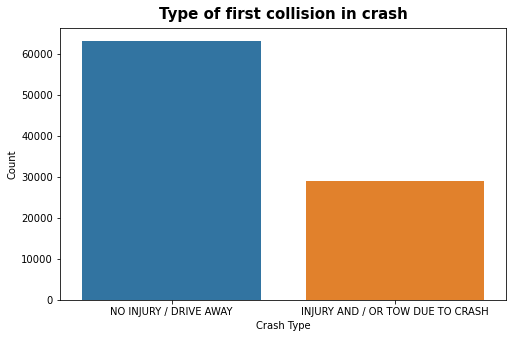

<Figure size 432x288 with 0 Axes>

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.CRASH_TYPE, ax=ax)
ax.set_title("Type of first collision in crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Crash Type')
ax.set_ylabel('Count')
plt.show()
plt.savefig('./img/crach_type.png')

## ESTIMATED DAMAGE

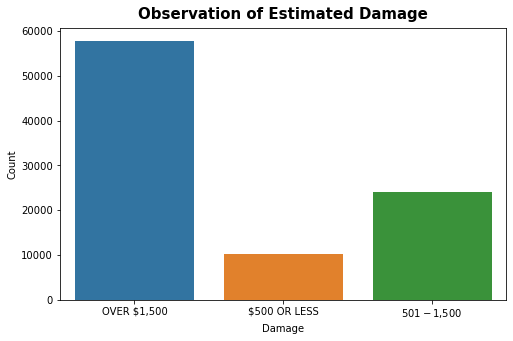

<Figure size 432x288 with 0 Axes>

In [60]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.DAMAGE, ax=ax)
ax.set_title("Observation of Estimated Damage", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Damage')
ax.set_ylabel('Count')
plt.show()
plt.savefig('./img/damage.png')

## MOST SEVERE INGURY

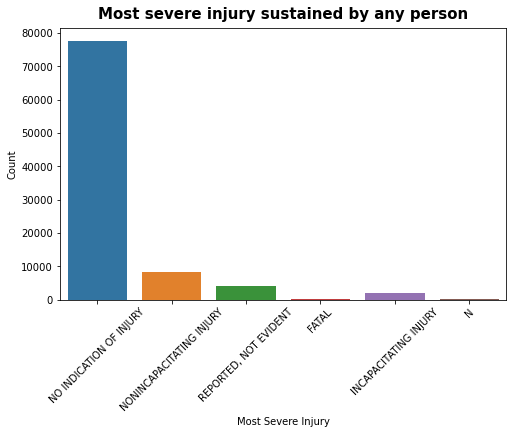

<Figure size 432x288 with 0 Axes>

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.MOST_SEVERE_INJURY, ax=ax)
ax.set_title("Most severe injury sustained by any person",
             fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Most Severe Injury')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()
plt.savefig('./img/Most_Severe_Injury.png')

## WEATHER CONDITION

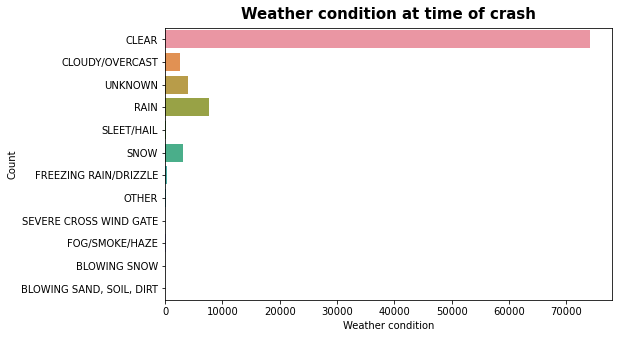

<Figure size 432x288 with 0 Axes>

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(y=df.WEATHER_CONDITION, data=df, ax=ax)
ax.set_title("Weather condition at time of crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Weather condition')
ax.set_ylabel('Count')
plt.show()
plt.savefig('./img/Weathercondition.png')

## ROAD SURFACE CONDITION

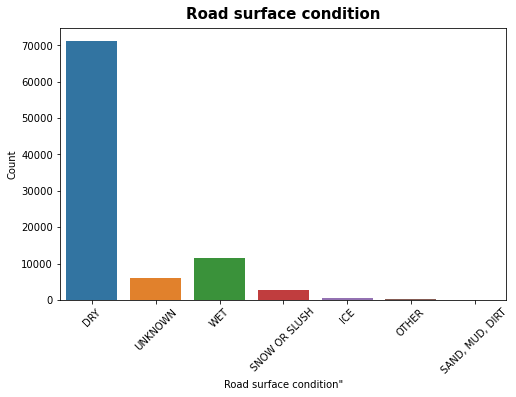

<Figure size 432x288 with 0 Axes>

In [63]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.ROADWAY_SURFACE_COND, ax=ax)
ax.set_title("Road surface condition", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Road surface condition"')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()
plt.savefig('./img/road_surface_condition.png')

<H1>Posted Speed Limit Analysis<H/>

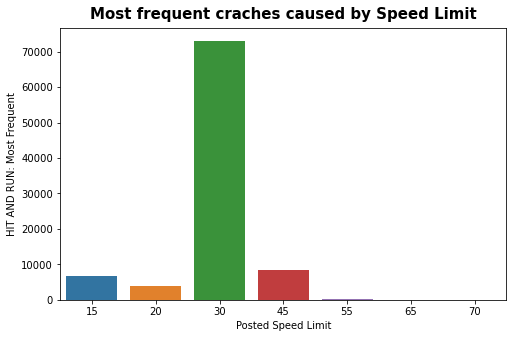

<Figure size 432x288 with 0 Axes>

In [64]:
speed_hit_and_run = df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({'HIT_AND_RUN_I': 'describe'})
speed_hit_and_run.columns = [speed_hit_and_run.columns.to_list()[0][0]]+\
                            ['_'.join(x) for x in speed_hit_and_run.columns[1:]]

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='POSTED_SPEED_LIMIT', y='HIT_AND_RUN_I_count', data=speed_hit_and_run, orient='v', ax=ax)
ax.set_title("Most frequent craches caused by Speed Limit", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('HIT AND RUN: Most Frequent')
plt.show()
plt.savefig('./img/speed_hit_and_run.png')

## Speed Limit by Number of units-related

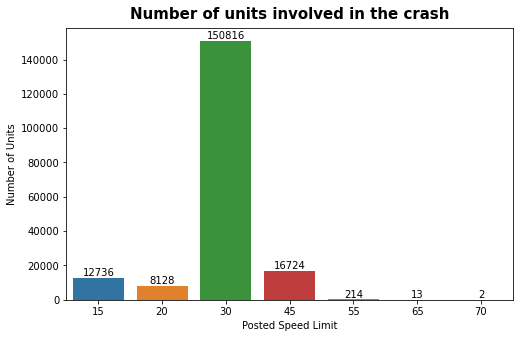

<Figure size 432x288 with 0 Axes>

In [65]:
speed_unit = df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({'NUM_UNITS': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_speed_unit=sns.barplot(x='POSTED_SPEED_LIMIT', y='NUM_UNITS', data=speed_unit, ax=ax)
for index, row in speed_unit.iterrows():
    sns_speed_unit.text(x=row.name,
                        y=row.NUM_UNITS,
                        s=round(row.NUM_UNITS),
                        color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("Number of units involved in the crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('Number of Units')
plt.show()
plt.savefig('./img/speed_unit.png')

## INJURIES ANALYSIS

## Number of injuries by Speed Limit-related

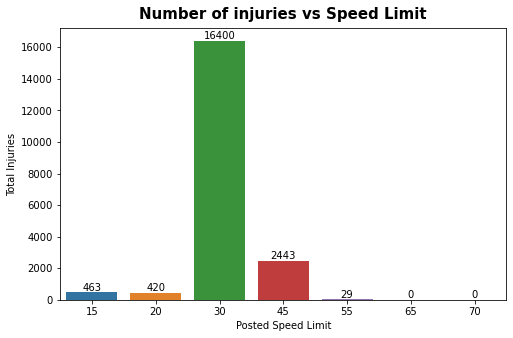

<Figure size 432x288 with 0 Axes>

In [66]:
speed_injuries = df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_speed_injured=sns.barplot(x='POSTED_SPEED_LIMIT', y='INJURIES_TOTAL', data=speed_injuries, ax=ax)
for index, row in speed_injuries.iterrows():
    sns_speed_injured.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("Number of injuries vs Speed Limit", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('Total Injuries')
plt.show()
plt.show()
plt.savefig('./img/speed_injures.png')

## Number of injuries by Month-related

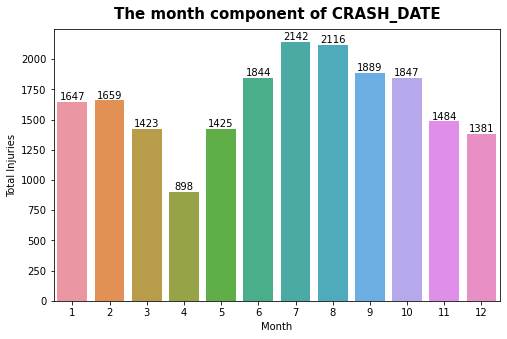

<Figure size 432x288 with 0 Axes>

In [67]:
injuries_month = df.groupby('CRASH_MONTH', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_month=sns.barplot(x='CRASH_MONTH', y='INJURIES_TOTAL', data=injuries_month, ax=ax)
for index, row in injuries_month.iterrows():
    sns_injuries_month.text(x=row.name,
                            y=row.INJURIES_TOTAL,
                            s=round(row.INJURIES_TOTAL),
                            color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The month component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Month')
ax.set_ylabel('Total Injuries')
plt.show()
plt.savefig('./img/injuries_month.png')

##  Number of injuries by Day of Week-related

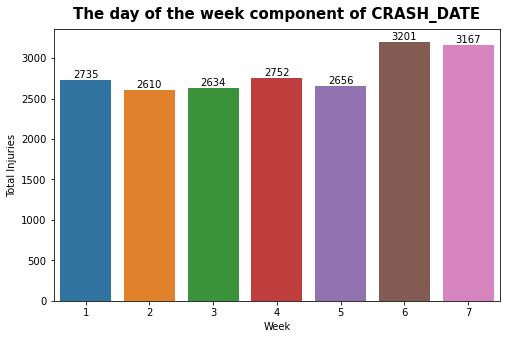

<Figure size 432x288 with 0 Axes>

In [68]:
injuries_week = df.groupby('CRASH_DAY_OF_WEEK', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_week=sns.barplot(x='CRASH_DAY_OF_WEEK', y='INJURIES_TOTAL', data=injuries_week, ax=ax)
for index, row in injuries_week.iterrows():
    sns_injuries_week.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The day of the week component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Week')
ax.set_ylabel('Total Injuries')
plt.show()
plt.savefig('./img/injuries_week.png')

##  Number of injuries by Hour-related

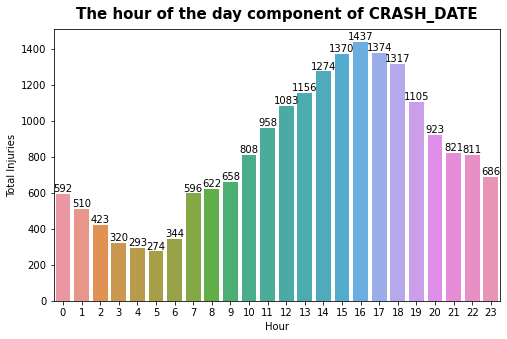

<Figure size 432x288 with 0 Axes>

In [69]:
injuries_hour = df.groupby('CRASH_HOUR', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_hour=sns.barplot(x='CRASH_HOUR', y='INJURIES_TOTAL', data=injuries_hour, ax=ax)

for index, row in injuries_hour.iterrows():
    sns_injuries_hour.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The hour of the day component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Hour')
ax.set_ylabel('Total Injuries')
plt.show()
plt.savefig('./img/injuries_hour.png')

## Number of injuries by Roadway Condition-related

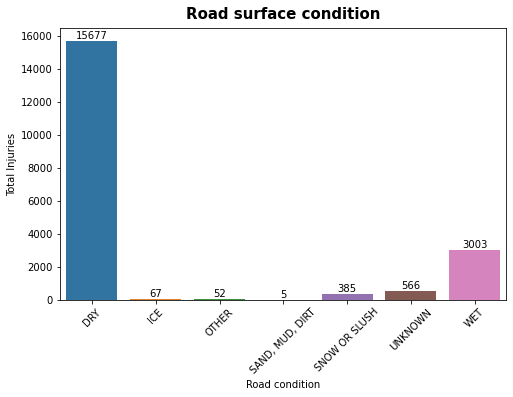

<Figure size 432x288 with 0 Axes>

In [70]:
injuries_road = df.groupby('ROADWAY_SURFACE_COND', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_road=sns.barplot(x='ROADWAY_SURFACE_COND', y='INJURIES_TOTAL', data=injuries_road, ax=ax)

for index, row in injuries_road.iterrows():
    sns_injuries_road.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom', ha="center", fontsize=10)
    sns.barplot(x='ROADWAY_SURFACE_COND', y='INJURIES_TOTAL', data=injuries_road, ax=ax)
plt.xticks(rotation=45)
ax.set_title("Road surface condition", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Road condition')
ax.set_ylabel('Total Injuries')
plt.show()
plt.savefig('./img/Road_surface_condition.png')

## PREPROCESSING

In [71]:
df_features = df[sorted(features_cols)].copy()

In [72]:
df_features_info = Dframe(df_features)

In [73]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ALIGNMENT                92092 non-null  object
 1   DEVICE_CONDITION         92092 non-null  object
 2   FIRST_CRASH_TYPE         92092 non-null  object
 3   INTERSECTION_RELATED_I   92092 non-null  object
 4   LIGHTING_CONDITION       92092 non-null  object
 5   NOT_RIGHT_OF_WAY_I       92092 non-null  object
 6   POSTED_SPEED_LIMIT       92092 non-null  int64 
 7   PRIM_CONTRIBUTORY_CAUSE  92092 non-null  object
 8   ROADWAY_SURFACE_COND     92092 non-null  object
 9   ROAD_DEFECT              92092 non-null  object
 10  TRAFFICWAY_TYPE          92092 non-null  object
 11  TRAFFIC_CONTROL_DEVICE   92092 non-null  object
 12  WEATHER_CONDITION        92092 non-null  object
 13  WORKERS_PRESENT_I        92092 non-null  object
 14  WORK_ZONE_I              92092 non-nul

In [74]:
category_cols.update(('TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
                    'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
                     'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I','WORK_ZONE_I', 'WORKERS_PRESENT_I'))

## Features Transformation using OneHotEncoder

In [75]:
ohe_features = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_features.fit(df_features[category_cols])

df_features_ohe = pd.concat([df_features.drop(labels=category_cols, axis=1),
                             pd.DataFrame(ohe_features.transform(df_features[category_cols]),
                                          columns=ohe_features.get_feature_names(list(category_cols)))],
                            axis=1)
df_features_ohe.drop(labels=['PRIM_CONTRIBUTORY_CAUSE'], axis=1, inplace=True)

## Target Transformation using OneHotEncoder

In [76]:
ohe_target     = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_target_ohe  = pd.DataFrame(ohe_target.fit_transform(df_features.PRIM_CONTRIBUTORY_CAUSE.values.reshape(-1,1)),
                         columns=ohe_target.categories_)

## MODELING

it's broad clear we're dealing with a multiclass & multioutput imbalanced dataset, this presents a different challenge than a binary classification problem.
fortunaly mostly 99% of classes are categorical except for POSTED_SPEED_LIMIT wich is the only numeric class

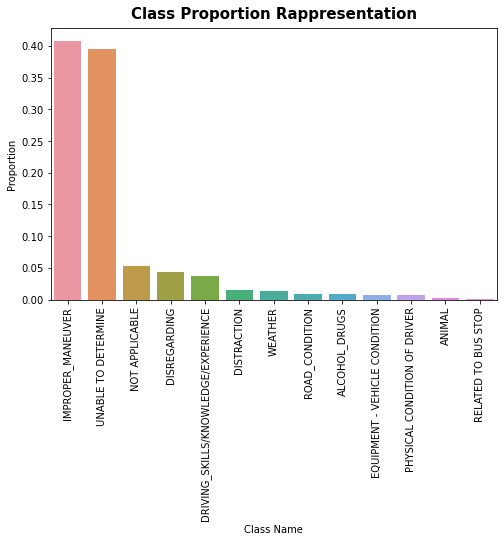

In [169]:
fig, ax = plt.subplots(figsize=(8,5))

g = sns.barplot(x=df_features.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize=True).index,
                y=df_features.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize=True),data=df_features)

plt.xticks(rotation=90)
ax.set_title("Class Proportion Rappresentation", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Class Name')
ax.set_ylabel('Proportion')
plt.show()

In [152]:
X = df_features_ohe
y = df_target_ohe.loc[:,'IMPROPER_MANEUVER']

In [151]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=264, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((64464, 111), (27628, 111), (64464,), (27628,))

## Decision Tree

In [83]:
class_weight_dct = dict()
class_weight_dct = dict(
    zip(
        np.unique(y),
        compute_class_weight(class_weight=class_weight_dct, classes=np.unique(y), y=np.ravel(np.array(y)))
    ))

In [146]:
dc_param={
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'random_state': 264
}

In [147]:
cls_tree = DecisionTreeClassifier(**dc_param)

In [148]:
model1 = cls_tree.fit(x_train, y_train)
model1_y_train_pred = model1.predict(x_train)

In [149]:
print(classification_report(y_train, model1_y_train_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77     38141
         1.0       0.65      0.83      0.73     26323

    accuracy                           0.75     64464
   macro avg       0.75      0.76      0.75     64464
weighted avg       0.77      0.75      0.75     64464



## Random Forest

In [91]:
cls_rf = RandomForestClassifier(class_weight='balanced', random_state=264)

In [92]:
model2 = cls_rf.fit(x_train, np.ravel(np.array(y_train)))

In [93]:
model2_y_train_pred = cls_rf.predict(x_train)

In [94]:
print(f'ROC_AUC Test: {roc_auc_score(y_train, model1_y_train_pred)}')

ROC_AUC Test: 0.7623054832175009


In [693]:
# [(est.get_depth(), est.tree_.max_depth, est.max_depth) for est in cls_rf.estimators_]

time: 109 µs


## RandomForestClassifier: Hyperparameters with GridSearchCV

In [128]:
rfc_param = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [25, 50, 75, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True],
    'oob_score': [True],
    'n_jobs': [4],
    'class_weight': ['balanced'],
    'max_samples': [500],
    'random_state': [264]
}

In [699]:
grid_search = GridSearchCV(cls_rf, param_grid=rfc_param, scoring='roc_auc', n_jobs=4, cv=2)

time: 877 µs


In [700]:
grid_search.fit(x_train, np.ravel(np.array(y_train)))

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=264),
             n_jobs=4,
             param_grid={'bootstrap': [True],
                         'class_weight': [{0.0: 0.8450668036998972,
                                           1.0: 1.2244973938942665},
                                          'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 25, 35, 65],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_samples': [500],
                         'min_samples_leaf': [2, 4, 6, 10],
                         'min_samples_split': [2, 4, 6, 10],
                         'n_estimators': [75, 100, 200, 400], 'n_jobs': [4],
                         'oob_score': [True], 'random_state': [264]},
             scoring='roc_auc')

time: 57min 25s


In [701]:
rf_best_params=grid_search.best_params_;rf_best_params

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 35,
 'max_features': 'auto',
 'max_samples': 500,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400,
 'n_jobs': 4,
 'oob_score': True,
 'random_state': 264}

time: 5.34 ms


In [702]:
print(f"{'Best Score':20} {grid_search.best_score_}")

Best Score           0.6965075388087427
time: 1.08 ms


In [96]:
rf_best_params = {'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 35,
 'max_features': 'auto',
 'max_samples': 500,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400,
 'n_jobs': 4,
 'oob_score': True,
 'random_state': 264}

In [108]:
cls_rf = RandomForestClassifier(**rf_best_params)

In [162]:
model3_train = cls_rf.fit(x_train, np.ravel(np.array(y_train)))

In [163]:
model3_y_train_pred = cls_rf.predict(x_train)

In [164]:
model3_test = cls_rf.fit(x_test, np.ravel(np.array(y_test)))

In [165]:
model3_y_test_pred = cls_rf.predict(x_test)

In [166]:
print(f'ROC_AUC Test: {roc_auc_score(y_train, model3_y_train_pred)}')

ROC_AUC Test: 0.6629386111588662


In [167]:
print(f'ROC_AUC Test: {roc_auc_score(y_test, model3_y_test_pred)}')

ROC_AUC Test: 0.6569795179837556


In [168]:
print(classification_report(y_test, model3_y_test_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67     16347
         1.0       0.55      0.71      0.62     11281

    accuracy                           0.65     27628
   macro avg       0.65      0.66      0.65     27628
weighted avg       0.67      0.65      0.65     27628



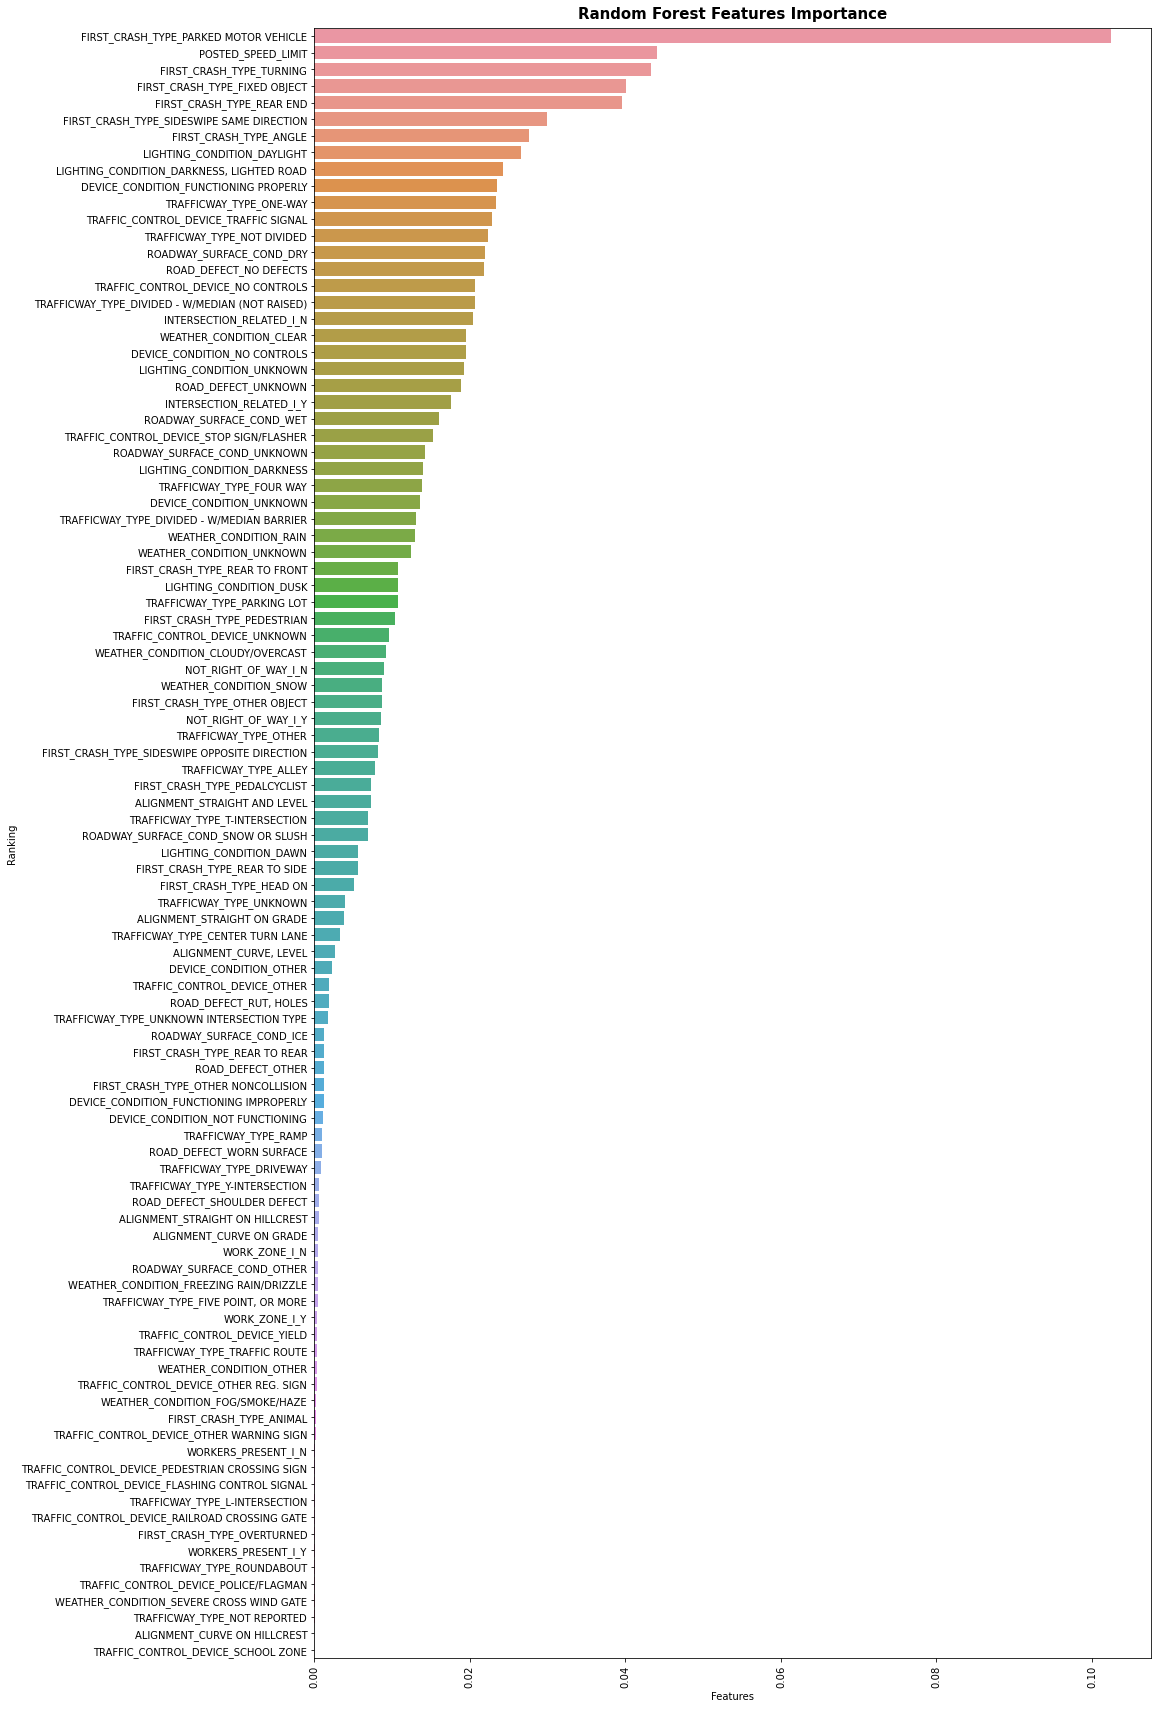

In [124]:
model2_df = pd.DataFrame({'features': x_train.columns,
                          'Ranking':cls_rf.feature_importances_})
                        
model2_df = model2_df[(model2_df.Ranking > 0)].sort_values(by='Ranking', ascending=False)

fig, ax = plt.subplots(figsize=(15,30))
g = sns.barplot(x='Ranking', y='features', data=model2_df)
plt.xticks(rotation=90)
ax.set_title("Random Forest Features Importance", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Features')
ax.set_ylabel('Ranking')
plt.show()

In [173]:
sampler = SMOTEN(random_state=264, n_jobs=4)

In [ ]:
X_res, y_res = sampler.fit_resample(x_train[x_train.columns.difference(['POSTED_SPEED_LIMIT'])], y_train)

In [269]:
rf = RandomForestClassifier(**rf_best_params)

In [270]:
m4 = rf.fit(X_res, np.ravel(np.array(y_res)))

In [273]:
m4_y_train_pred = cls_rf.predict(X_res)

In [279]:
print(f'ROC_AUC Test: {roc_auc_score(y_res, m4_y_train_pred)}')

ROC_AUC Test: 0.7501769749088908


In [ ]:
print('a')

## Interpreting Data